# Building neural networks in Tensorflow and Keras

# Introduction
  
In this guide we build on the experience gained from our neural network implementation in NumPy and scikit-learn
and use it to construct a neural network in Tensorflow. Once you have constructed a neural network in NumPy
and Tensorflow, building one in Keras is really quite trivial, though the performance may suffer.  
  
In our previous guide we used only one hidden layer, and in this we will use two. From this it should be quite
clear how to build one using an arbitrary number of hidden layers, using data structures such as Python lists or
NumPy arrays.

# Tensorflow
  
Tensorflow is an open source library machine learning library developed by the Google Brain team for internal use. It was released under the Apache 2.0 open source license in November 9, 2015.  
  
Tensorflow is a computational framework that allows you to construct machine learning models at different levels of abstraction, from high-level, object-oriented APIs like Keras, down to the C++ kernels that Tensorflow is built upon. The higher levels of abstraction are simpler to use, but less flexible, and your choice of implementation should reflect the problem you are trying to solve.  
  
Tensorflow uses a [dataflow graph](https://www.tensorflow.org/guide/graphs) to represent your computation
in terms of the dependencies between individual operations, such that you first build a Tensorflow **graph** to represent your model, and then create a Tensorflow **session** to run the graph.
  
In this guide we will analyze the same data as we did in our NumPy and scikit-learn tutorial, gathered
from the MNIST database of images. We will give an introduction to the lower level Python APIs, and see how we use them to build our graph. Then we will build (effectively) the same graph in Keras, to see just how simple solving a machine learning problem can be.  
  
If you prefer you can also take a look at the official guides on [low level APIs](https://www.tensorflow.org/guide/low_level_intro) and [Keras](https://www.tensorflow.org/guide/keras).

# Prerequisites

To follow this tutorial we require an installation of Python with the numerical package **NumPy**, either:  
1) Python 2.7.x  
2) Python 3.5.x or greater  
  
With a version of NumPy 1.0.x or greater.  
We will also use the packages **matplotlib**, **scikit-learn**, and **Seaborn**, though these are not strictly necessary.  
To run this notebook you also need an installation of **IPython** and **Jupyter Notebook**.  
  
# Anaconda
Anaconda is a free and open source Python and R distribution, that aims to simplify package management and deployment. Anaconda comes with more than 1000 data packages, as well as the Conda package and virtual environment manager. Anaconda is available on Linux, OS X and Windows systems, and contains nearly all prerequisite software; it comes highly recommended.  
  
# Pip package manager
If you do not wish to install Anaconda you may download Python from [here](https://www.python.org/downloads/),
or you can use package managers like **brew**, **apt**, **pacman**,...  
Python distributions come with their own package manager, **pip**, and once you have Python installed
you can run the following command:  
  
```pip install numpy matplotlib scikit-learn seaborn ipython jupyter```  
  
# Tensorflow
  
Follow these [guides](https://www.tensorflow.org/install/) to install Tensorflow.  
If you have Anaconda installed you may run the following command:  
  
```conda install tensorflow``` 
  
(You may run into minor problems with conflicting packages and versions).  

# 1) Collect and pre-process data

inputs = (n_inputs, pixel_width, pixel_height) = (1797, 8, 8)
labels = (n_inputs) = (1797,)
X = (n_inputs, n_features) = (1797, 64)


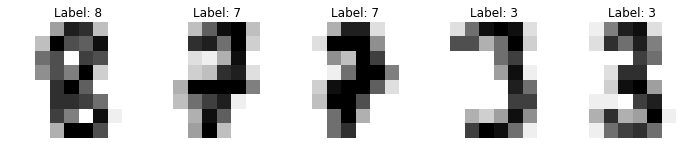

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print("inputs = (n_inputs, pixel_width, pixel_height) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print("X = (n_inputs, n_features) = " + str(inputs.shape))


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()


In [2]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# one-hot representation of labels
labels = to_categorical(labels)

# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

Using TensorFlow backend.


# 2) Define model and architecture

In [3]:
import tensorflow as tf

class NeuralNetworkTensorflow:
    def __init__(
        self,
        X_train,
        Y_train,
        X_test,
        Y_test,
        n_neurons_layer1=100,
        n_neurons_layer2=50,
        n_categories=2,
        epochs=10,
        batch_size=100,
        eta=0.1,
        lmbd=0.0,
    ):
        
        # keep track of number of steps
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
        self.n_inputs = X_train.shape[0]
        self.n_features = X_train.shape[1]
        self.n_neurons_layer1 = n_neurons_layer1
        self.n_neurons_layer2 = n_neurons_layer2
        self.n_categories = n_categories
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        # build network piece by piece
        # name scopes (with) are used to enforce creation of new variables
        # https://www.tensorflow.org/guide/variables
        self.create_placeholders()
        self.create_DNN()
        self.create_loss()
        self.create_optimiser()
        self.create_accuracy()
    
    def create_placeholders(self):
        # placeholders are fine here, but "Datasets" are the preferred method
        # of streaming data into a model
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.n_features), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_DNN(self):
        with tf.name_scope('DNN'):
            # the weights are stored to calculate regularization loss later
            
            # Fully connected layer 1
            self.W_fc1 = self.weight_variable([self.n_features, self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            b_fc1 = self.bias_variable([self.n_neurons_layer1], name='fc1', dtype=tf.float32)
            a_fc1 = tf.nn.sigmoid(tf.matmul(self.X, self.W_fc1) + b_fc1)
            
            # Fully connected layer 2
            self.W_fc2 = self.weight_variable([self.n_neurons_layer1, self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            b_fc2 = self.bias_variable([self.n_neurons_layer2], name='fc2', dtype=tf.float32)
            a_fc2 = tf.nn.sigmoid(tf.matmul(a_fc1, self.W_fc2) + b_fc2)
            
            # Output layer
            self.W_out = self.weight_variable([self.n_neurons_layer2, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc2, self.W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.Y, logits=self.z_out))
            
            regularizer_loss_fc1 = tf.nn.l2_loss(self.W_fc1)
            regularizer_loss_fc2 = tf.nn.l2_loss(self.W_fc2)
            regularizer_loss_out = tf.nn.l2_loss(self.W_out)
            regularizer_loss = self.lmbd*(regularizer_loss_fc1 + regularizer_loss_fc2 + regularizer_loss_out)
            
            self.loss = softmax_loss + regularizer_loss

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            probabilities = tf.nn.softmax(self.z_out)
            predictions = tf.argmax(probabilities, axis=1)
            labels = tf.argmax(self.Y, axis=1)
            
            correct_predictions = tf.equal(predictions, labels)
            correct_predictions = tf.cast(correct_predictions, tf.float32)
            self.accuracy = tf.reduce_mean(correct_predictions)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def fit(self):
        data_indices = np.arange(self.n_inputs)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epochs):
                for j in range(self.iterations):
                    chosen_datapoints = np.random.choice(data_indices, size=self.batch_size, replace=False)
                    batch_X, batch_Y = self.X_train[chosen_datapoints], self.Y_train[chosen_datapoints]
            
                    sess.run([DNN.loss, DNN.optimizer],
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y})
                    accuracy = sess.run(DNN.accuracy,
                        feed_dict={DNN.X: batch_X,
                                   DNN.Y: batch_Y})
                    step = sess.run(DNN.global_step)
    
            self.train_loss, self.train_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_train,
                           DNN.Y: self.Y_train})
        
            self.test_loss, self.test_accuracy = sess.run([DNN.loss, DNN.accuracy],
                feed_dict={DNN.X: self.X_test,
                           DNN.Y: self.Y_test})

In [4]:
epochs = 100
batch_size = 100
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 10

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)


In [5]:
DNN_tf = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = NeuralNetworkTensorflow(X_train, Y_train, X_test, Y_test,
                                      n_neurons_layer1, n_neurons_layer2, n_categories,
                                      epochs=epochs, batch_size=batch_size, eta=eta, lmbd=lmbd)
        DNN.fit()
        
        DNN_tf[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % DNN.test_accuracy)
        print()
        

Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.089

Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.089

Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.106

Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.114

Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.111

Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.167

Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.125

Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.064

Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.083

Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.086

Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.089

Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 0.106

Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 0.117

Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 0.092

Learning rate =  0.001
Lambda =  1e-05
Test accuracy: 0.197

Learning rate =  0.001
Lambda =  0.0001
Test accuracy: 0.194

Learning rate =  0.001
Lam

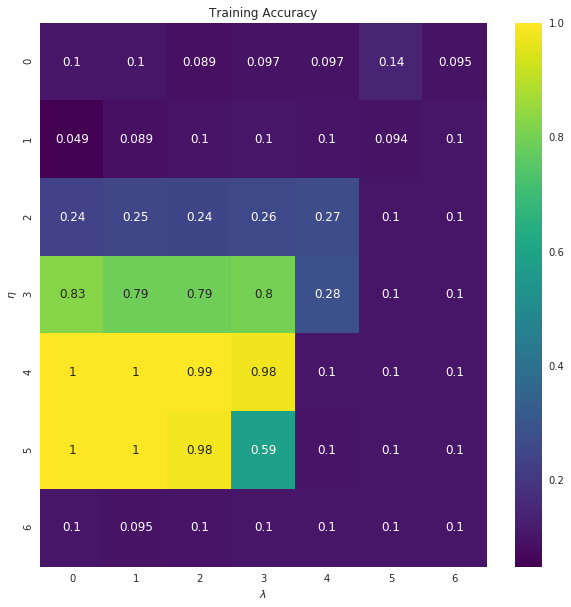

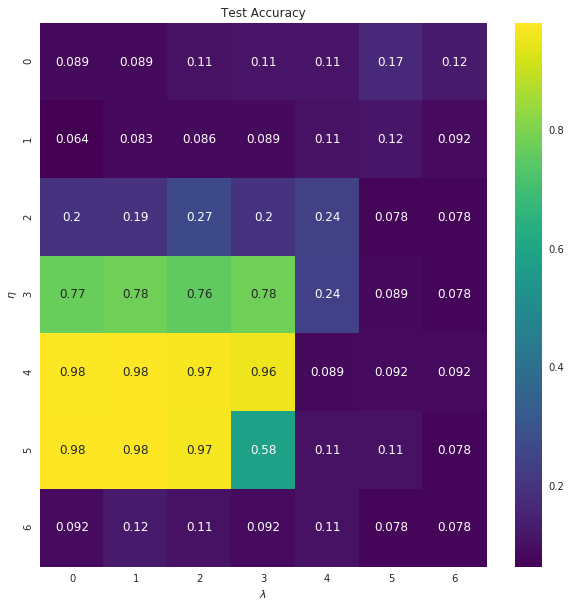

In [6]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_tf[i][j]

        train_accuracy[i][j] = DNN.train_accuracy
        test_accuracy[i][j] = DNN.test_accuracy

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()


In [7]:
# optional
# we can use log files to visualize our graph in Tensorboard
writer = tf.summary.FileWriter('logs/')
writer.add_graph(tf.get_default_graph())


# Keras
  
Keras is a high level neural network [API](https://en.wikipedia.org/wiki/Application_programming_interface)
that supports Tensorflow, CTNK and Theano as backends.  
If you have Tensorflow installed Keras is available through the *tf.keras* module.  
If you have Anaconda installed you may run the following command:  
  
```conda install keras```  
  
Alternatively, if you have Tensorflow or one of the other supported backends install you may use the pip package manager:  
  
```pip install keras```  
  
(Installation instructions [here](https://keras.io/)).

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import SGD

def create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories, eta, lmbd):
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='sigmoid', kernel_regularizer=l2(lmbd)))
    model.add(Dense(n_neurons_layer2, activation='sigmoid', kernel_regularizer=l2(lmbd)))
    model.add(Dense(n_categories, activation='softmax'))
    
    sgd = SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model


In [9]:
DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories,
                                         eta=eta, lmbd=lmbd)
        DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(X_test, Y_test)
        
        DNN_keras[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()
        

360/360 [==============================] - 0s 515us/step
Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.086

360/360 [==============================] - 0s 549us/step
Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.078

360/360 [==============================] - 0s 618us/step
Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.044

360/360 [==============================] - 0s 588us/step
Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.117

360/360 [==============================] - 0s 610us/step
Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.056

360/360 [==============================] - 0s 723us/step
Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.128

360/360 [==============================] - 0s 635us/step
Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.128

360/360 [==============================] - 0s 671us/step
Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.092

360/360 [==============================] - 0s 665us/step
Lea

360/360 [==============================] - 0s 34us/step


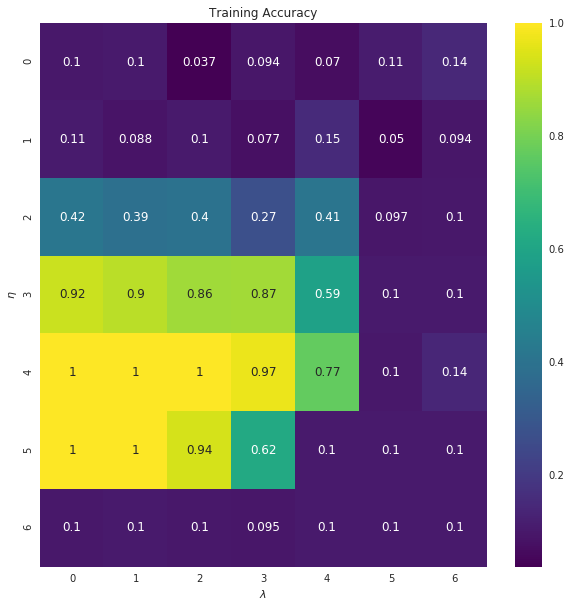

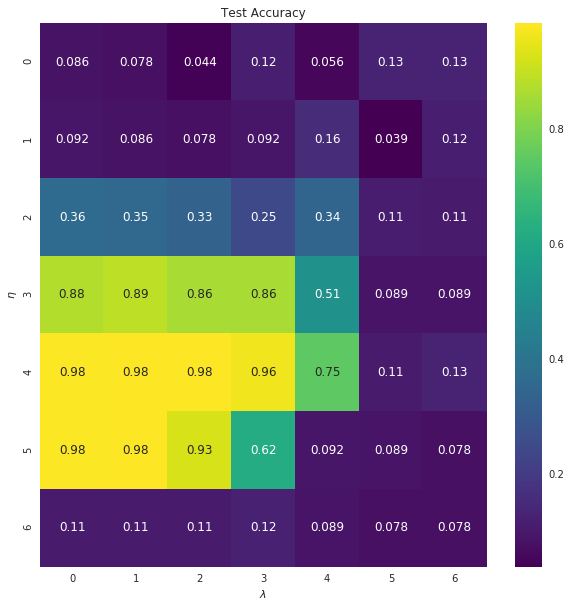

In [10]:
# optional
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_keras[i][j]

        train_accuracy[i][j] = DNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test, Y_test)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()
